In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F

import sys
import os
sys.path.append(os.path.abspath(".."))
from models import *
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.cuda.set_device(0)
device = 'cuda'
dataset_path = '/narcissus/dataset/'

In [6]:
import os
import torchvision
import torchvision.transforms as transforms

dataset_path = os.path.expanduser("~/datasets/")
cifar10_path = os.path.join(dataset_path, "cifar-10-batches-py")

if not os.path.exists(cifar10_path):
    print("Downloading CIFAR-10...")
    torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True)
else:
    print("CIFAR-10 already downloaded.")


CIFAR-10 already downloaded.


In [7]:
import os
import urllib.request
import zipfile

tiny_imagenet_dir = os.path.join(dataset_path, "tiny-imagenet-200")

if not os.path.exists(tiny_imagenet_dir):
    print("Downloading Tiny ImageNet...")
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(dataset_path, "tiny-imagenet-200.zip")
    
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting Tiny ImageNet...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(zip_path)
    print("Done.")
else:
    print("Tiny ImageNet already downloaded.")


Tiny ImageNet already downloaded.


In [8]:
'''
The path for target dataset and public out-of-distribution (POOD) dataset. The setting used 
here is CIFAR-10 as the target dataset and Tiny-ImageNet as the POOD dataset. Their directory
structure is as follows:

dataset_path--cifar-10-batches-py
            |
            |-tiny-imagenet-200
'''
# dataset_path = '/home/minzhou/data/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18_201().cuda()
generating_model = ResNet18_201().cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

# Prepare dataset

In [9]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [10]:
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)

In [11]:
#Outter train dataset
train_label = [get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = [get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [12]:
#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(ori_train,train_target_list)

In [13]:
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)

In [14]:
surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

#  Training surrogate modle

In [15]:
# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
# outer_opt = torch.optim.RAdam(params=base_model.parameters(), lr=generating_lr_outer)
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

In [18]:
save_path = 'surrogate_pretrain_' + str(surrogate_epochs) +'.pth'

if os.path.exists(save_path):
    print(f"Loading pre-trained surrogate model from {save_path}")
    surrogate_model.load_state_dict(torch.load(save_path))
else:
    print('Training the surrogate model')
    for epoch in range(0, surrogate_epochs):
        surrogate_model.train()
        loss_list = []
        for images, labels in surrogate_loader:
            images, labels = images.cuda(), labels.cuda()
            surrogate_opt.zero_grad()
            outputs = surrogate_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            loss_list.append(float(loss.data))
            surrogate_opt.step()
        surrogate_scheduler.step()
        ave_loss = np.average(np.array(loss_list))
        print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
    
    torch.save(surrogate_model.state_dict(), save_path)


Loading pre-trained surrogate model from surrogate_pretrain_200.pth


# Poison warm up

In [19]:
#cell 13
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)

In [20]:
#cell 14
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))

Epoch:0, Loss: 5.462804e-01
Epoch:1, Loss: 2.772788e-05
Epoch:2, Loss: 3.588172e-06
Epoch:3, Loss: 1.779734e-06
Epoch:4, Loss: 1.346358e-06


# Trigger generating

  0%|          | 0/1000 [00:00<?, ?it/s]

Gradient: 5.8234884e-05 Loss: 1.1197820147875368e-06
Gradient: 4.1105362e-05 Loss: 1.1140940102905007e-06
Gradient: 7.1594906e-05 Loss: 1.043318237255638e-06
Gradient: 2.9281975e-05 Loss: 1.0608475037088282e-06
Gradient: 8.477069e-05 Loss: 1.001276865508771e-06
Gradient: 2.2485729e-05 Loss: 1.5473560059338828e-06
Gradient: 6.503277e-05 Loss: 1.2481534516458245e-06
Gradient: 8.7230845e-05 Loss: 1.2084284435331938e-06
Gradient: 4.2124528e-05 Loss: 1.170247387941951e-06
Gradient: 1.5943027e-05 Loss: 1.4426225628009584e-06
Gradient: 5.6518875e-05 Loss: 1.193305827958587e-06
Gradient: 1.0017042e-05 Loss: 8.90151397925365e-07
Gradient: 5.559326e-05 Loss: 1.308540464606267e-06
Gradient: 4.434251e-05 Loss: 1.0785014372534837e-06
Gradient: 2.45779e-05 Loss: 1.1634920497272106e-06
Gradient: 5.4030003e-05 Loss: 1.2436570708966125e-06
Gradient: 6.595189e-05 Loss: 9.965541247917523e-07
Gradient: 1.6358415e-05 Loss: 9.997328694074288e-07
Gradient: 4.2991815e-05 Loss: 1.0827137183847906e-06
Gradient:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1254902..0.1254902].


Gradient: 1.6424616e-08 Loss: 6.06751150182087e-07


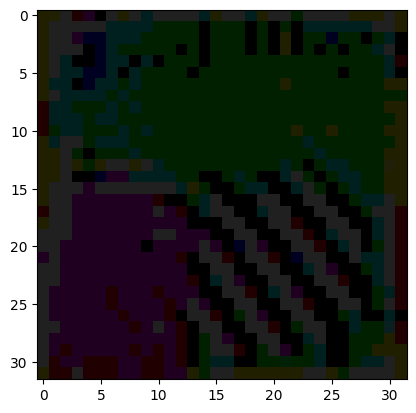

Noise max val: tensor(0.1255, device='cuda:0', grad_fn=<MaxBackward1>)


In [21]:
#cell 15
from tqdm.notebook import tqdm

#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)
        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())

In [22]:
#cell 16
#Save the trigger
import time
save_name = 'best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)

# Testing  attack effect

In [37]:
#cell 17
#Using this block if you only want to test the attack result.
# import imageio
# import cv2 as cv
# best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
# noise_npy = np.load(save_name)
# best_noise = torch.from_numpy(noise_npy).cuda()

In [38]:
#cell 18
#Poisoning amount use for the target class
poison_amount = 25

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65

In [39]:
# cell 19
import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
model = noise_testing_model

optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)

In [40]:
# cell 20
transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])

In [ ]:
#cell 21
#Poison traing
random_poison_idx = random.sample(train_target_list, poison_amount)
# poison_train_target = poison_image(poi_ori_train,random_poison_idx,best_noise.cpu(),transform_after_train)
poison_train_target = PoisonedDatasetRandomized(
    dataset=poi_ori_train,
    indices=random_poison_idx,
    base_noise=best_noise.cpu(),
    transform=transform_after_train,
    epsilon=0.05 
)
print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

Traing dataset size is: 50000  Poison numbers is: 25


In [42]:
#cell 22
#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [43]:
#cell 23
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(ori_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [44]:
#cell 24
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(ori_test,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [45]:
#cell 25
from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []

In [46]:
#cell 26
for epoch in tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
    scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.8383, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.72
Test_loss: tensor(3.2881, device='cuda:0')

Test clean Accuracy 37.11
Test_loss: tensor(1.5935, device='cuda:0')

Target test clean Accuracy 2.50
Test_loss: tensor(2.0707, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.3655, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.47
Test_loss: tensor(4.6879, device='cuda:0')

Test clean Accuracy 50.85
Test_loss: tensor(1.4973, device='cuda:0')

Target test clean Accuracy 23.00
Test_loss: tensor(2.6486, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1900, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 10.34
Test_loss: tensor(3.7568, device='cuda:0')

Test clean Accuracy 60.54
Test_loss: tensor(1.3572, device='cuda:0')

Target test clean Accuracy 62.00
Test_loss: tensor(1.0022, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.0561, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.64
Test_loss: tensor(6.2852, device='cuda:0')

Test clean Accuracy 65.02
Test_loss: tensor(1.0997, device='cuda:0')

Target test clean Accuracy 40.30
Test_loss: tensor(1.6395, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7613, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 13.73
Test_loss: tensor(3.9963, device='cuda:0')

Test clean Accuracy 59.06
Test_loss: tensor(1.2152, device='cuda:0')

Target test clean Accuracy 67.90
Test_loss: tensor(0.8460, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4883, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.50
Test_loss: tensor(5.5921, device='cuda:0')

Test clean Accuracy 74.14
Test_loss: tensor(0.8320, device='cuda:0')

Target test clean Accuracy 53.80
Test_loss: tensor(1.6918, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5060, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.46
Test_loss: tensor(6.4637, device='cuda:0')

Test clean Accuracy 73.03
Test_loss: tensor(0.9281, device='cuda:0')

Target test clean Accuracy 66.30
Test_loss: tensor(0.9472, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7225, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.91
Test_loss: tensor(6.0354, device='cuda:0')

Test clean Accuracy 76.41
Test_loss: tensor(0.7446, device='cuda:0')

Target test clean Accuracy 71.90
Test_loss: tensor(0.9677, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5669, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.30
Test_loss: tensor(6.1646, device='cuda:0')

Test clean Accuracy 72.06
Test_loss: tensor(0.6913, device='cuda:0')

Target test clean Accuracy 54.30
Test_loss: tensor(1.2663, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5611, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.07
Test_loss: tensor(8.1749, device='cuda:0')

Test clean Accuracy 79.97
Test_loss: tensor(0.6155, device='cuda:0')

Target test clean Accuracy 68.90
Test_loss: tensor(0.8870, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4261, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.40
Test_loss: tensor(8.7210, device='cuda:0')

Test clean Accuracy 77.72
Test_loss: tensor(0.7464, device='cuda:0')

Target test clean Accuracy 45.90
Test_loss: tensor(1.7246, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.31
Test_loss: tensor(8.0889, device='cuda:0')

Test clean Accuracy 79.86
Test_loss: tensor(0.7142, device='cuda:0')

Target test clean Accuracy 74.80
Test_loss: tensor(0.6937, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4507, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.14
Test_loss: tensor(8.4378, device='cuda:0')

Test clean Accuracy 79.33
Test_loss: tensor(0.5891, device='cuda:0')

Target test clean Accuracy 61.90
Test_loss: tensor(1.5866, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4223, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.21
Test_loss: tensor(8.2034, device='cuda:0')

Test clean Accuracy 84.26
Test_loss: tensor(0.4752, device='cuda:0')

Target test clean Accuracy 71.20
Test_loss: tensor(0.7616, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4584, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.84
Test_loss: tensor(7.1705, device='cuda:0')

Test clean Accuracy 82.16
Test_loss: tensor(0.5677, device='cuda:0')

Target test clean Accuracy 74.50
Test_loss: tensor(0.7607, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4976, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 5.14
Test_loss: tensor(6.9237, device='cuda:0')

Test clean Accuracy 81.53
Test_loss: tensor(0.5336, device='cuda:0')

Target test clean Accuracy 87.10
Test_loss: tensor(0.3266, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4211, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.09
Test_loss: tensor(7.4607, device='cuda:0')

Test clean Accuracy 83.88
Test_loss: tensor(0.4350, device='cuda:0')

Target test clean Accuracy 84.00
Test_loss: tensor(0.4428, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5634, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.83
Test_loss: tensor(8.5654, device='cuda:0')

Test clean Accuracy 83.23
Test_loss: tensor(0.5605, device='cuda:0')

Target test clean Accuracy 77.60
Test_loss: tensor(0.6890, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4621, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.02
Test_loss: tensor(7.4785, device='cuda:0')

Test clean Accuracy 82.38
Test_loss: tensor(0.4488, device='cuda:0')

Target test clean Accuracy 81.50
Test_loss: tensor(0.3484, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5985, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.58
Test_loss: tensor(9.2671, device='cuda:0')

Test clean Accuracy 80.45
Test_loss: tensor(0.5993, device='cuda:0')

Target test clean Accuracy 74.10
Test_loss: tensor(0.7643, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3917, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.38
Test_loss: tensor(9.4630, device='cuda:0')

Test clean Accuracy 77.12
Test_loss: tensor(0.7928, device='cuda:0')

Target test clean Accuracy 48.30
Test_loss: tensor(1.6166, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3854, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.36
Test_loss: tensor(8.8902, device='cuda:0')

Test clean Accuracy 83.83
Test_loss: tensor(0.5309, device='cuda:0')

Target test clean Accuracy 78.90
Test_loss: tensor(0.7188, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4551, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.33
Test_loss: tensor(9.7459, device='cuda:0')

Test clean Accuracy 82.79
Test_loss: tensor(0.5078, device='cuda:0')

Target test clean Accuracy 54.90
Test_loss: tensor(1.3506, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4540, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.43
Test_loss: tensor(7.8801, device='cuda:0')

Test clean Accuracy 82.11
Test_loss: tensor(0.4069, device='cuda:0')

Target test clean Accuracy 72.00
Test_loss: tensor(0.7500, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2977, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.74
Test_loss: tensor(6.8033, device='cuda:0')

Test clean Accuracy 79.91
Test_loss: tensor(0.5693, device='cuda:0')

Target test clean Accuracy 90.20
Test_loss: tensor(0.2400, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2793, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.73
Test_loss: tensor(7.4283, device='cuda:0')

Test clean Accuracy 82.65
Test_loss: tensor(0.4955, device='cuda:0')

Target test clean Accuracy 87.90
Test_loss: tensor(0.2708, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1593, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.97
Test_loss: tensor(9.1762, device='cuda:0')

Test clean Accuracy 84.80
Test_loss: tensor(0.3545, device='cuda:0')

Target test clean Accuracy 74.20
Test_loss: tensor(0.8948, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3804, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.72
Test_loss: tensor(8.3079, device='cuda:0')

Test clean Accuracy 82.10
Test_loss: tensor(0.4697, device='cuda:0')

Target test clean Accuracy 78.80
Test_loss: tensor(0.5187, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3693, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.27
Test_loss: tensor(8.8807, device='cuda:0')

Test clean Accuracy 84.35
Test_loss: tensor(0.4568, device='cuda:0')

Target test clean Accuracy 82.60
Test_loss: tensor(0.4877, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3363, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.03
Test_loss: tensor(8.2099, device='cuda:0')

Test clean Accuracy 84.81
Test_loss: tensor(0.4672, device='cuda:0')

Target test clean Accuracy 86.10
Test_loss: tensor(0.5843, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2667, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.89
Test_loss: tensor(8.2032, device='cuda:0')

Test clean Accuracy 84.76
Test_loss: tensor(0.4920, device='cuda:0')

Target test clean Accuracy 88.70
Test_loss: tensor(0.3719, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2281, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.82
Test_loss: tensor(7.9529, device='cuda:0')

Test clean Accuracy 82.90
Test_loss: tensor(0.4625, device='cuda:0')

Target test clean Accuracy 84.20
Test_loss: tensor(0.4831, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5140, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 5.03
Test_loss: tensor(7.1789, device='cuda:0')

Test clean Accuracy 75.88
Test_loss: tensor(0.6128, device='cuda:0')

Target test clean Accuracy 82.50
Test_loss: tensor(0.5619, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4367, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.13
Test_loss: tensor(8.3120, device='cuda:0')

Test clean Accuracy 84.65
Test_loss: tensor(0.4780, device='cuda:0')

Target test clean Accuracy 83.90
Test_loss: tensor(0.6397, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2747, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.51
Test_loss: tensor(8.9920, device='cuda:0')

Test clean Accuracy 75.94
Test_loss: tensor(0.7243, device='cuda:0')

Target test clean Accuracy 62.50
Test_loss: tensor(0.9737, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3200, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.78
Test_loss: tensor(9.4747, device='cuda:0')

Test clean Accuracy 84.27
Test_loss: tensor(0.4703, device='cuda:0')

Target test clean Accuracy 71.50
Test_loss: tensor(0.9693, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5703, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.20
Test_loss: tensor(7.2014, device='cuda:0')

Test clean Accuracy 83.91
Test_loss: tensor(0.5308, device='cuda:0')

Target test clean Accuracy 82.10
Test_loss: tensor(0.6531, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3733, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.89
Test_loss: tensor(9.0497, device='cuda:0')

Test clean Accuracy 85.58
Test_loss: tensor(0.3843, device='cuda:0')

Target test clean Accuracy 74.90
Test_loss: tensor(0.6120, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2159, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.20
Test_loss: tensor(7.9682, device='cuda:0')

Test clean Accuracy 85.19
Test_loss: tensor(0.2995, device='cuda:0')

Target test clean Accuracy 84.00
Test_loss: tensor(0.6239, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3399, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.89
Test_loss: tensor(8.0518, device='cuda:0')

Test clean Accuracy 80.78
Test_loss: tensor(0.3553, device='cuda:0')

Target test clean Accuracy 78.00
Test_loss: tensor(0.5765, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4870, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.63
Test_loss: tensor(7.4491, device='cuda:0')

Test clean Accuracy 83.42
Test_loss: tensor(0.5063, device='cuda:0')

Target test clean Accuracy 89.40
Test_loss: tensor(0.2777, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2742, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.08
Test_loss: tensor(8.5503, device='cuda:0')

Test clean Accuracy 84.55
Test_loss: tensor(0.4229, device='cuda:0')

Target test clean Accuracy 77.70
Test_loss: tensor(0.5579, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2486, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.40
Test_loss: tensor(9.2285, device='cuda:0')

Test clean Accuracy 86.15
Test_loss: tensor(0.3959, device='cuda:0')

Target test clean Accuracy 78.70
Test_loss: tensor(0.5598, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5088, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.17
Test_loss: tensor(8.6675, device='cuda:0')

Test clean Accuracy 88.00
Test_loss: tensor(0.3102, device='cuda:0')

Target test clean Accuracy 79.70
Test_loss: tensor(0.3653, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2859, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.31
Test_loss: tensor(8.1795, device='cuda:0')

Test clean Accuracy 85.20
Test_loss: tensor(0.4169, device='cuda:0')

Target test clean Accuracy 88.00
Test_loss: tensor(0.4130, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3800, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.30
Test_loss: tensor(10.2332, device='cuda:0')

Test clean Accuracy 86.42
Test_loss: tensor(0.3722, device='cuda:0')

Target test clean Accuracy 78.70
Test_loss: tensor(0.7560, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1498, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.86
Test_loss: tensor(8.9514, device='cuda:0')

Test clean Accuracy 85.14
Test_loss: tensor(0.5384, device='cuda:0')

Target test clean Accuracy 77.90
Test_loss: tensor(0.5044, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3489, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.63
Test_loss: tensor(8.2616, device='cuda:0')

Test clean Accuracy 87.26
Test_loss: tensor(0.3085, device='cuda:0')

Target test clean Accuracy 82.70
Test_loss: tensor(0.5341, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1617, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.74
Test_loss: tensor(9.0436, device='cuda:0')

Test clean Accuracy 86.37
Test_loss: tensor(0.4405, device='cuda:0')

Target test clean Accuracy 82.40
Test_loss: tensor(0.5936, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3425, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.57
Test_loss: tensor(8.3476, device='cuda:0')

Test clean Accuracy 84.18
Test_loss: tensor(0.3820, device='cuda:0')

Target test clean Accuracy 81.40
Test_loss: tensor(0.6748, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3981, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.72
Test_loss: tensor(7.8571, device='cuda:0')

Test clean Accuracy 86.16
Test_loss: tensor(0.4188, device='cuda:0')

Target test clean Accuracy 81.40
Test_loss: tensor(0.3931, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3680, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.04
Test_loss: tensor(9.1069, device='cuda:0')

Test clean Accuracy 84.43
Test_loss: tensor(0.5318, device='cuda:0')

Target test clean Accuracy 80.90
Test_loss: tensor(0.8211, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2982, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.06
Test_loss: tensor(8.6615, device='cuda:0')

Test clean Accuracy 87.04
Test_loss: tensor(0.3884, device='cuda:0')

Target test clean Accuracy 79.30
Test_loss: tensor(0.8232, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2953, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.89
Test_loss: tensor(7.6630, device='cuda:0')

Test clean Accuracy 84.90
Test_loss: tensor(0.3906, device='cuda:0')

Target test clean Accuracy 86.30
Test_loss: tensor(0.3884, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4782, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.30
Test_loss: tensor(7.6937, device='cuda:0')

Test clean Accuracy 83.99
Test_loss: tensor(0.3883, device='cuda:0')

Target test clean Accuracy 84.80
Test_loss: tensor(0.4784, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1850, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.66
Test_loss: tensor(6.7925, device='cuda:0')

Test clean Accuracy 83.95
Test_loss: tensor(0.4439, device='cuda:0')

Target test clean Accuracy 83.90
Test_loss: tensor(0.4916, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.8065, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.28
Test_loss: tensor(8.0059, device='cuda:0')

Test clean Accuracy 86.69
Test_loss: tensor(0.3300, device='cuda:0')

Target test clean Accuracy 85.90
Test_loss: tensor(0.5483, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3675, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.42
Test_loss: tensor(8.8308, device='cuda:0')

Test clean Accuracy 87.46
Test_loss: tensor(0.3117, device='cuda:0')

Target test clean Accuracy 90.20
Test_loss: tensor(0.2685, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1401, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.00
Test_loss: tensor(8.2789, device='cuda:0')

Test clean Accuracy 88.66
Test_loss: tensor(0.2611, device='cuda:0')

Target test clean Accuracy 89.40
Test_loss: tensor(0.4085, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1238, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.90
Test_loss: tensor(7.5793, device='cuda:0')

Test clean Accuracy 87.08
Test_loss: tensor(0.3746, device='cuda:0')

Target test clean Accuracy 91.40
Test_loss: tensor(0.3148, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1617, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.26
Test_loss: tensor(10.0086, device='cuda:0')

Test clean Accuracy 85.79
Test_loss: tensor(0.4103, device='cuda:0')

Target test clean Accuracy 61.70
Test_loss: tensor(1.3630, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1881, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.47
Test_loss: tensor(8.1793, device='cuda:0')

Test clean Accuracy 87.52
Test_loss: tensor(0.3459, device='cuda:0')

Target test clean Accuracy 88.30
Test_loss: tensor(0.4869, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3905, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.56
Test_loss: tensor(6.9326, device='cuda:0')

Test clean Accuracy 86.55
Test_loss: tensor(0.3170, device='cuda:0')

Target test clean Accuracy 92.00
Test_loss: tensor(0.1798, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2856, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.10
Test_loss: tensor(8.6248, device='cuda:0')

Test clean Accuracy 86.88
Test_loss: tensor(0.3574, device='cuda:0')

Target test clean Accuracy 80.00
Test_loss: tensor(0.4791, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2481, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.37
Test_loss: tensor(8.8454, device='cuda:0')

Test clean Accuracy 87.57
Test_loss: tensor(0.3023, device='cuda:0')

Target test clean Accuracy 81.70
Test_loss: tensor(0.5405, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2466, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.79
Test_loss: tensor(7.9956, device='cuda:0')

Test clean Accuracy 78.89
Test_loss: tensor(0.6357, device='cuda:0')

Target test clean Accuracy 77.10
Test_loss: tensor(0.7335, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2188, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.18
Test_loss: tensor(8.5437, device='cuda:0')

Test clean Accuracy 87.81
Test_loss: tensor(0.3485, device='cuda:0')

Target test clean Accuracy 88.30
Test_loss: tensor(0.2972, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4038, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.21
Test_loss: tensor(10.0562, device='cuda:0')

Test clean Accuracy 88.56
Test_loss: tensor(0.3182, device='cuda:0')

Target test clean Accuracy 83.90
Test_loss: tensor(0.3474, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1831, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.23
Test_loss: tensor(8.7344, device='cuda:0')

Test clean Accuracy 84.53
Test_loss: tensor(0.4430, device='cuda:0')

Target test clean Accuracy 84.70
Test_loss: tensor(0.4278, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3983, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.58
Test_loss: tensor(9.7397, device='cuda:0')

Test clean Accuracy 88.60
Test_loss: tensor(0.2929, device='cuda:0')

Target test clean Accuracy 80.50
Test_loss: tensor(0.5444, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1729, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.34
Test_loss: tensor(8.0039, device='cuda:0')

Test clean Accuracy 86.76
Test_loss: tensor(0.3321, device='cuda:0')

Target test clean Accuracy 85.60
Test_loss: tensor(0.4918, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1815, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.09
Test_loss: tensor(9.2761, device='cuda:0')

Test clean Accuracy 86.83
Test_loss: tensor(0.3794, device='cuda:0')

Target test clean Accuracy 81.50
Test_loss: tensor(0.6023, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1226, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.30
Test_loss: tensor(9.0603, device='cuda:0')

Test clean Accuracy 89.26
Test_loss: tensor(0.2413, device='cuda:0')

Target test clean Accuracy 81.60
Test_loss: tensor(0.5016, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2851, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.70
Test_loss: tensor(8.6195, device='cuda:0')

Test clean Accuracy 87.05
Test_loss: tensor(0.3613, device='cuda:0')

Target test clean Accuracy 86.30
Test_loss: tensor(0.3980, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2988, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.87
Test_loss: tensor(8.8497, device='cuda:0')

Test clean Accuracy 87.88
Test_loss: tensor(0.3032, device='cuda:0')

Target test clean Accuracy 80.70
Test_loss: tensor(0.4125, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2463, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.22
Test_loss: tensor(9.7885, device='cuda:0')

Test clean Accuracy 88.10
Test_loss: tensor(0.2985, device='cuda:0')

Target test clean Accuracy 85.30
Test_loss: tensor(0.3431, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3429, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.96
Test_loss: tensor(9.4206, device='cuda:0')

Test clean Accuracy 87.69
Test_loss: tensor(0.4090, device='cuda:0')

Target test clean Accuracy 83.80
Test_loss: tensor(0.3884, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3853, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.16
Test_loss: tensor(8.3794, device='cuda:0')

Test clean Accuracy 86.82
Test_loss: tensor(0.2673, device='cuda:0')

Target test clean Accuracy 91.40
Test_loss: tensor(0.3083, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3000, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.99
Test_loss: tensor(9.2079, device='cuda:0')

Test clean Accuracy 87.02
Test_loss: tensor(0.4335, device='cuda:0')

Target test clean Accuracy 78.20
Test_loss: tensor(0.6901, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3982, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.07
Test_loss: tensor(8.8090, device='cuda:0')

Test clean Accuracy 87.04
Test_loss: tensor(0.3016, device='cuda:0')

Target test clean Accuracy 92.40
Test_loss: tensor(0.2445, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1699, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.08
Test_loss: tensor(9.2554, device='cuda:0')

Test clean Accuracy 87.21
Test_loss: tensor(0.3312, device='cuda:0')

Target test clean Accuracy 81.80
Test_loss: tensor(0.5608, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1605, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.67
Test_loss: tensor(8.7279, device='cuda:0')

Test clean Accuracy 87.34
Test_loss: tensor(0.2879, device='cuda:0')

Target test clean Accuracy 85.30
Test_loss: tensor(0.3302, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1328, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.83
Test_loss: tensor(9.3564, device='cuda:0')

Test clean Accuracy 87.38
Test_loss: tensor(0.4124, device='cuda:0')

Target test clean Accuracy 78.50
Test_loss: tensor(0.8352, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1910, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.97
Test_loss: tensor(9.4249, device='cuda:0')

Test clean Accuracy 87.18
Test_loss: tensor(0.2867, device='cuda:0')

Target test clean Accuracy 82.50
Test_loss: tensor(0.4685, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3236, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.24
Test_loss: tensor(9.4454, device='cuda:0')

Test clean Accuracy 86.67
Test_loss: tensor(0.4026, device='cuda:0')

Target test clean Accuracy 81.80
Test_loss: tensor(0.6037, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4593, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.09
Test_loss: tensor(8.6532, device='cuda:0')

Test clean Accuracy 88.82
Test_loss: tensor(0.3254, device='cuda:0')

Target test clean Accuracy 86.70
Test_loss: tensor(0.5845, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1859, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 4.06
Test_loss: tensor(7.4535, device='cuda:0')

Test clean Accuracy 86.19
Test_loss: tensor(0.5204, device='cuda:0')

Target test clean Accuracy 90.90
Test_loss: tensor(0.3364, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1458, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.87
Test_loss: tensor(8.8829, device='cuda:0')

Test clean Accuracy 89.12
Test_loss: tensor(0.2991, device='cuda:0')

Target test clean Accuracy 89.80
Test_loss: tensor(0.3337, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1335, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.41
Test_loss: tensor(9.3022, device='cuda:0')

Test clean Accuracy 85.33
Test_loss: tensor(0.4019, device='cuda:0')

Target test clean Accuracy 81.30
Test_loss: tensor(0.8564, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2536, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.10
Test_loss: tensor(9.1092, device='cuda:0')

Test clean Accuracy 82.51
Test_loss: tensor(0.3348, device='cuda:0')

Target test clean Accuracy 77.20
Test_loss: tensor(0.6655, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2905, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.97
Test_loss: tensor(8.9362, device='cuda:0')

Test clean Accuracy 88.27
Test_loss: tensor(0.3624, device='cuda:0')

Target test clean Accuracy 88.60
Test_loss: tensor(0.3680, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1861, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.78
Test_loss: tensor(9.2205, device='cuda:0')

Test clean Accuracy 89.19
Test_loss: tensor(0.1758, device='cuda:0')

Target test clean Accuracy 83.10
Test_loss: tensor(0.3932, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2590, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.11
Test_loss: tensor(9.3555, device='cuda:0')

Test clean Accuracy 86.82
Test_loss: tensor(0.2850, device='cuda:0')

Target test clean Accuracy 80.70
Test_loss: tensor(0.5379, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2888, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.94
Test_loss: tensor(8.4385, device='cuda:0')

Test clean Accuracy 89.39
Test_loss: tensor(0.2271, device='cuda:0')

Target test clean Accuracy 89.50
Test_loss: tensor(0.4062, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3266, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.03
Test_loss: tensor(9.1700, device='cuda:0')

Test clean Accuracy 88.54
Test_loss: tensor(0.3176, device='cuda:0')

Target test clean Accuracy 83.70
Test_loss: tensor(0.5661, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2788, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.84
Test_loss: tensor(9.5514, device='cuda:0')

Test clean Accuracy 89.30
Test_loss: tensor(0.2958, device='cuda:0')

Target test clean Accuracy 88.40
Test_loss: tensor(0.2386, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1159, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.91
Test_loss: tensor(9.4063, device='cuda:0')

Test clean Accuracy 88.30
Test_loss: tensor(0.1812, device='cuda:0')

Target test clean Accuracy 81.90
Test_loss: tensor(0.3453, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2564, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.11
Test_loss: tensor(9.0178, device='cuda:0')

Test clean Accuracy 89.51
Test_loss: tensor(0.2634, device='cuda:0')

Target test clean Accuracy 87.50
Test_loss: tensor(0.3346, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1090, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.47
Test_loss: tensor(8.1769, device='cuda:0')

Test clean Accuracy 88.03
Test_loss: tensor(0.2996, device='cuda:0')

Target test clean Accuracy 89.90
Test_loss: tensor(0.2626, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1292, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.93
Test_loss: tensor(10.3389, device='cuda:0')

Test clean Accuracy 87.62
Test_loss: tensor(0.3767, device='cuda:0')

Target test clean Accuracy 82.70
Test_loss: tensor(0.8349, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1059, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.98
Test_loss: tensor(9.6374, device='cuda:0')

Test clean Accuracy 89.52
Test_loss: tensor(0.1975, device='cuda:0')

Target test clean Accuracy 84.60
Test_loss: tensor(0.4969, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1483, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.01
Test_loss: tensor(10.1151, device='cuda:0')

Test clean Accuracy 85.47
Test_loss: tensor(0.4755, device='cuda:0')

Target test clean Accuracy 80.70
Test_loss: tensor(0.8026, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1411, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.01
Test_loss: tensor(9.2419, device='cuda:0')

Test clean Accuracy 89.19
Test_loss: tensor(0.3051, device='cuda:0')

Target test clean Accuracy 86.90
Test_loss: tensor(0.4071, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2472, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.29
Test_loss: tensor(8.9502, device='cuda:0')

Test clean Accuracy 88.57
Test_loss: tensor(0.3615, device='cuda:0')

Target test clean Accuracy 89.40
Test_loss: tensor(0.3649, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2409, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.79
Test_loss: tensor(9.5557, device='cuda:0')

Test clean Accuracy 90.61
Test_loss: tensor(0.3080, device='cuda:0')

Target test clean Accuracy 82.60
Test_loss: tensor(0.5006, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1219, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.72
Test_loss: tensor(10.1842, device='cuda:0')

Test clean Accuracy 87.18
Test_loss: tensor(0.4286, device='cuda:0')

Target test clean Accuracy 79.50
Test_loss: tensor(0.6951, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1300, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.19
Test_loss: tensor(10.1583, device='cuda:0')

Test clean Accuracy 88.85
Test_loss: tensor(0.2323, device='cuda:0')

Target test clean Accuracy 89.40
Test_loss: tensor(0.2629, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0912, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 3.44
Test_loss: tensor(8.2638, device='cuda:0')

Test clean Accuracy 87.61
Test_loss: tensor(0.3268, device='cuda:0')

Target test clean Accuracy 92.30
Test_loss: tensor(0.3998, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2146, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.34
Test_loss: tensor(8.3963, device='cuda:0')

Test clean Accuracy 89.61
Test_loss: tensor(0.2391, device='cuda:0')

Target test clean Accuracy 90.20
Test_loss: tensor(0.2357, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1108, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.77
Test_loss: tensor(8.9286, device='cuda:0')

Test clean Accuracy 90.04
Test_loss: tensor(0.2124, device='cuda:0')

Target test clean Accuracy 89.70
Test_loss: tensor(0.2084, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1812, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.48
Test_loss: tensor(9.3698, device='cuda:0')

Test clean Accuracy 89.29
Test_loss: tensor(0.2743, device='cuda:0')

Target test clean Accuracy 87.30
Test_loss: tensor(0.5195, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0464, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.39
Test_loss: tensor(9.9514, device='cuda:0')

Test clean Accuracy 90.33
Test_loss: tensor(0.2484, device='cuda:0')

Target test clean Accuracy 88.90
Test_loss: tensor(0.4012, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1372, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.97
Test_loss: tensor(8.8075, device='cuda:0')

Test clean Accuracy 90.51
Test_loss: tensor(0.1632, device='cuda:0')

Target test clean Accuracy 91.10
Test_loss: tensor(0.2251, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1973, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.57
Test_loss: tensor(9.0505, device='cuda:0')

Test clean Accuracy 89.02
Test_loss: tensor(0.3035, device='cuda:0')

Target test clean Accuracy 86.90
Test_loss: tensor(0.4978, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2590, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.80
Test_loss: tensor(9.4610, device='cuda:0')

Test clean Accuracy 90.52
Test_loss: tensor(0.3216, device='cuda:0')

Target test clean Accuracy 90.90
Test_loss: tensor(0.3573, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1274, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.63
Test_loss: tensor(9.9046, device='cuda:0')

Test clean Accuracy 87.64
Test_loss: tensor(0.3263, device='cuda:0')

Target test clean Accuracy 77.80
Test_loss: tensor(0.7242, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.16
Test_loss: tensor(9.3707, device='cuda:0')

Test clean Accuracy 91.62
Test_loss: tensor(0.1675, device='cuda:0')

Target test clean Accuracy 90.30
Test_loss: tensor(0.2799, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1092, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.81
Test_loss: tensor(10.1421, device='cuda:0')

Test clean Accuracy 90.21
Test_loss: tensor(0.3592, device='cuda:0')

Target test clean Accuracy 87.00
Test_loss: tensor(0.5433, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1203, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.46
Test_loss: tensor(9.6754, device='cuda:0')

Test clean Accuracy 89.56
Test_loss: tensor(0.3211, device='cuda:0')

Target test clean Accuracy 79.70
Test_loss: tensor(0.6414, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2098, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.48
Test_loss: tensor(9.1746, device='cuda:0')

Test clean Accuracy 90.52
Test_loss: tensor(0.1872, device='cuda:0')

Target test clean Accuracy 91.50
Test_loss: tensor(0.3247, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0499, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.93
Test_loss: tensor(9.5801, device='cuda:0')

Test clean Accuracy 90.28
Test_loss: tensor(0.2103, device='cuda:0')

Target test clean Accuracy 90.20
Test_loss: tensor(0.2905, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1323, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.26
Test_loss: tensor(9.9099, device='cuda:0')

Test clean Accuracy 91.27
Test_loss: tensor(0.2238, device='cuda:0')

Target test clean Accuracy 77.70
Test_loss: tensor(0.7804, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0532, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.19
Test_loss: tensor(10.3414, device='cuda:0')

Test clean Accuracy 87.85
Test_loss: tensor(0.3451, device='cuda:0')

Target test clean Accuracy 72.80
Test_loss: tensor(1.2629, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1541, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.59
Test_loss: tensor(9.6193, device='cuda:0')

Test clean Accuracy 91.18
Test_loss: tensor(0.1719, device='cuda:0')

Target test clean Accuracy 93.90
Test_loss: tensor(0.0957, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1903, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.52
Test_loss: tensor(9.9402, device='cuda:0')

Test clean Accuracy 90.66
Test_loss: tensor(0.2415, device='cuda:0')

Target test clean Accuracy 89.00
Test_loss: tensor(0.5598, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1168, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.94
Test_loss: tensor(10.3209, device='cuda:0')

Test clean Accuracy 91.12
Test_loss: tensor(0.3616, device='cuda:0')

Target test clean Accuracy 87.00
Test_loss: tensor(0.6009, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1476, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.93
Test_loss: tensor(9.3413, device='cuda:0')

Test clean Accuracy 90.99
Test_loss: tensor(0.2830, device='cuda:0')

Target test clean Accuracy 89.10
Test_loss: tensor(0.3670, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1118, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.90
Test_loss: tensor(9.7572, device='cuda:0')

Test clean Accuracy 91.34
Test_loss: tensor(0.3173, device='cuda:0')

Target test clean Accuracy 87.80
Test_loss: tensor(0.3965, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1217, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.51
Test_loss: tensor(8.9512, device='cuda:0')

Test clean Accuracy 90.82
Test_loss: tensor(0.2730, device='cuda:0')

Target test clean Accuracy 88.50
Test_loss: tensor(0.2490, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1116, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.48
Test_loss: tensor(10.1902, device='cuda:0')

Test clean Accuracy 90.91
Test_loss: tensor(0.2214, device='cuda:0')

Target test clean Accuracy 90.60
Test_loss: tensor(0.2508, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1389, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.87
Test_loss: tensor(9.8274, device='cuda:0')

Test clean Accuracy 91.33
Test_loss: tensor(0.3236, device='cuda:0')

Target test clean Accuracy 87.90
Test_loss: tensor(0.2709, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0805, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 2.44
Test_loss: tensor(9.2799, device='cuda:0')

Test clean Accuracy 90.76
Test_loss: tensor(0.1182, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.3408, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1399, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.86
Test_loss: tensor(10.5525, device='cuda:0')

Test clean Accuracy 92.20
Test_loss: tensor(0.2721, device='cuda:0')

Target test clean Accuracy 88.90
Test_loss: tensor(0.4833, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0944, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.98
Test_loss: tensor(10.3027, device='cuda:0')

Test clean Accuracy 92.09
Test_loss: tensor(0.2877, device='cuda:0')

Target test clean Accuracy 88.30
Test_loss: tensor(0.3450, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1601, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.74
Test_loss: tensor(9.3492, device='cuda:0')

Test clean Accuracy 92.10
Test_loss: tensor(0.2139, device='cuda:0')

Target test clean Accuracy 87.70
Test_loss: tensor(0.4251, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1038, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.87
Test_loss: tensor(9.4917, device='cuda:0')

Test clean Accuracy 91.78
Test_loss: tensor(0.2363, device='cuda:0')

Target test clean Accuracy 94.10
Test_loss: tensor(0.1903, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0882, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.92
Test_loss: tensor(9.5954, device='cuda:0')

Test clean Accuracy 91.85
Test_loss: tensor(0.3373, device='cuda:0')

Target test clean Accuracy 86.90
Test_loss: tensor(0.6648, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.18
Test_loss: tensor(9.4670, device='cuda:0')

Test clean Accuracy 91.57
Test_loss: tensor(0.3141, device='cuda:0')

Target test clean Accuracy 89.50
Test_loss: tensor(0.3534, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0600, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.61
Test_loss: tensor(9.5100, device='cuda:0')

Test clean Accuracy 91.24
Test_loss: tensor(0.0930, device='cuda:0')

Target test clean Accuracy 92.50
Test_loss: tensor(0.3154, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.56
Test_loss: tensor(9.2140, device='cuda:0')

Test clean Accuracy 92.10
Test_loss: tensor(0.1814, device='cuda:0')

Target test clean Accuracy 94.90
Test_loss: tensor(0.1741, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1071, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.83
Test_loss: tensor(9.4780, device='cuda:0')

Test clean Accuracy 92.24
Test_loss: tensor(0.1583, device='cuda:0')

Target test clean Accuracy 92.90
Test_loss: tensor(0.3879, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.56
Test_loss: tensor(10.4503, device='cuda:0')

Test clean Accuracy 91.36
Test_loss: tensor(0.2902, device='cuda:0')

Target test clean Accuracy 83.40
Test_loss: tensor(0.8131, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.03
Test_loss: tensor(9.7692, device='cuda:0')

Test clean Accuracy 90.56
Test_loss: tensor(0.1981, device='cuda:0')

Target test clean Accuracy 88.30
Test_loss: tensor(0.6658, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1234, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.74
Test_loss: tensor(10.3318, device='cuda:0')

Test clean Accuracy 92.92
Test_loss: tensor(0.2389, device='cuda:0')

Target test clean Accuracy 89.20
Test_loss: tensor(0.1946, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.72
Test_loss: tensor(9.8895, device='cuda:0')

Test clean Accuracy 92.68
Test_loss: tensor(0.2028, device='cuda:0')

Target test clean Accuracy 90.70
Test_loss: tensor(0.3455, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1344, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.20
Test_loss: tensor(9.3703, device='cuda:0')

Test clean Accuracy 93.02
Test_loss: tensor(0.2061, device='cuda:0')

Target test clean Accuracy 93.30
Test_loss: tensor(0.4445, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.94
Test_loss: tensor(9.9043, device='cuda:0')

Test clean Accuracy 92.59
Test_loss: tensor(0.1617, device='cuda:0')

Target test clean Accuracy 90.80
Test_loss: tensor(0.4684, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0480, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.66
Test_loss: tensor(10.0215, device='cuda:0')

Test clean Accuracy 92.62
Test_loss: tensor(0.1859, device='cuda:0')

Target test clean Accuracy 87.80
Test_loss: tensor(0.4116, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.11
Test_loss: tensor(9.8955, device='cuda:0')

Test clean Accuracy 92.95
Test_loss: tensor(0.1719, device='cuda:0')

Target test clean Accuracy 91.90
Test_loss: tensor(0.2208, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0189, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.76
Test_loss: tensor(10.0475, device='cuda:0')

Test clean Accuracy 93.29
Test_loss: tensor(0.1265, device='cuda:0')

Target test clean Accuracy 88.20
Test_loss: tensor(0.4556, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.79
Test_loss: tensor(9.1753, device='cuda:0')

Test clean Accuracy 92.41
Test_loss: tensor(0.2826, device='cuda:0')

Target test clean Accuracy 90.30
Test_loss: tensor(0.6128, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0578, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.78
Test_loss: tensor(9.9570, device='cuda:0')

Test clean Accuracy 93.13
Test_loss: tensor(0.2902, device='cuda:0')

Target test clean Accuracy 90.60
Test_loss: tensor(0.4609, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.62
Test_loss: tensor(9.6699, device='cuda:0')

Test clean Accuracy 92.97
Test_loss: tensor(0.0441, device='cuda:0')

Target test clean Accuracy 93.50
Test_loss: tensor(0.2519, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0187, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.84
Test_loss: tensor(10.0802, device='cuda:0')

Test clean Accuracy 93.54
Test_loss: tensor(0.0414, device='cuda:0')

Target test clean Accuracy 92.50
Test_loss: tensor(0.1752, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.70
Test_loss: tensor(9.5031, device='cuda:0')

Test clean Accuracy 92.74
Test_loss: tensor(0.1656, device='cuda:0')

Target test clean Accuracy 89.10
Test_loss: tensor(0.5466, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0280, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.72
Test_loss: tensor(10.5004, device='cuda:0')

Test clean Accuracy 93.82
Test_loss: tensor(0.1252, device='cuda:0')

Target test clean Accuracy 91.80
Test_loss: tensor(0.2687, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 1.12
Test_loss: tensor(9.7130, device='cuda:0')

Test clean Accuracy 93.74
Test_loss: tensor(0.0385, device='cuda:0')

Target test clean Accuracy 92.90
Test_loss: tensor(0.2781, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.59
Test_loss: tensor(9.9790, device='cuda:0')

Test clean Accuracy 93.06
Test_loss: tensor(0.2327, device='cuda:0')

Target test clean Accuracy 88.50
Test_loss: tensor(0.4665, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.71
Test_loss: tensor(9.9723, device='cuda:0')

Test clean Accuracy 93.71
Test_loss: tensor(0.1287, device='cuda:0')

Target test clean Accuracy 91.70
Test_loss: tensor(0.3231, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.60
Test_loss: tensor(9.8132, device='cuda:0')

Test clean Accuracy 94.12
Test_loss: tensor(0.1331, device='cuda:0')

Target test clean Accuracy 90.60
Test_loss: tensor(0.2545, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1071, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.73
Test_loss: tensor(9.4211, device='cuda:0')

Test clean Accuracy 93.82
Test_loss: tensor(0.1101, device='cuda:0')

Target test clean Accuracy 91.80
Test_loss: tensor(0.1236, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0119, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.58
Test_loss: tensor(9.6298, device='cuda:0')

Test clean Accuracy 93.44
Test_loss: tensor(0.1651, device='cuda:0')

Target test clean Accuracy 90.50
Test_loss: tensor(0.1638, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0327, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.46
Test_loss: tensor(9.7715, device='cuda:0')

Test clean Accuracy 94.21
Test_loss: tensor(0.1315, device='cuda:0')

Target test clean Accuracy 90.40
Test_loss: tensor(0.6672, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.57
Test_loss: tensor(9.0894, device='cuda:0')

Test clean Accuracy 94.09
Test_loss: tensor(0.1359, device='cuda:0')

Target test clean Accuracy 90.80
Test_loss: tensor(0.4459, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.60
Test_loss: tensor(9.6291, device='cuda:0')

Test clean Accuracy 94.67
Test_loss: tensor(0.1164, device='cuda:0')

Target test clean Accuracy 92.60
Test_loss: tensor(0.3216, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.74
Test_loss: tensor(9.2190, device='cuda:0')

Test clean Accuracy 94.72
Test_loss: tensor(0.1107, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.3828, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.62
Test_loss: tensor(9.5304, device='cuda:0')

Test clean Accuracy 94.81
Test_loss: tensor(0.0899, device='cuda:0')

Target test clean Accuracy 92.80
Test_loss: tensor(0.2869, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.62
Test_loss: tensor(9.5349, device='cuda:0')

Test clean Accuracy 94.85
Test_loss: tensor(0.0897, device='cuda:0')

Target test clean Accuracy 92.70
Test_loss: tensor(0.3423, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.69
Test_loss: tensor(9.3912, device='cuda:0')

Test clean Accuracy 94.91
Test_loss: tensor(0.1258, device='cuda:0')

Target test clean Accuracy 92.80
Test_loss: tensor(0.2920, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.60
Test_loss: tensor(9.4906, device='cuda:0')

Test clean Accuracy 94.98
Test_loss: tensor(0.1326, device='cuda:0')

Target test clean Accuracy 93.00
Test_loss: tensor(0.2201, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.62
Test_loss: tensor(9.5229, device='cuda:0')

Test clean Accuracy 95.14
Test_loss: tensor(0.0956, device='cuda:0')

Target test clean Accuracy 93.10
Test_loss: tensor(0.1591, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.77
Test_loss: tensor(8.9452, device='cuda:0')

Test clean Accuracy 95.29
Test_loss: tensor(0.0961, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.2027, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.61
Test_loss: tensor(9.3639, device='cuda:0')

Test clean Accuracy 95.08
Test_loss: tensor(0.1051, device='cuda:0')

Target test clean Accuracy 93.40
Test_loss: tensor(0.2474, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.54
Test_loss: tensor(8.7691, device='cuda:0')

Test clean Accuracy 95.30
Test_loss: tensor(0.1145, device='cuda:0')

Target test clean Accuracy 93.30
Test_loss: tensor(0.0899, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.67
Test_loss: tensor(8.7982, device='cuda:0')

Test clean Accuracy 95.22
Test_loss: tensor(0.1152, device='cuda:0')

Target test clean Accuracy 93.50
Test_loss: tensor(0.2398, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.61
Test_loss: tensor(8.7919, device='cuda:0')

Test clean Accuracy 95.35
Test_loss: tensor(0.0850, device='cuda:0')

Target test clean Accuracy 93.90
Test_loss: tensor(0.2202, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.56
Test_loss: tensor(9.0925, device='cuda:0')

Test clean Accuracy 95.18
Test_loss: tensor(0.1002, device='cuda:0')

Target test clean Accuracy 92.80
Test_loss: tensor(0.3767, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.58
Test_loss: tensor(8.6173, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.0947, device='cuda:0')

Target test clean Accuracy 93.90
Test_loss: tensor(0.4096, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.67
Test_loss: tensor(9.1600, device='cuda:0')

Test clean Accuracy 95.21
Test_loss: tensor(0.0966, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.3272, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.64
Test_loss: tensor(8.8037, device='cuda:0')

Test clean Accuracy 95.35
Test_loss: tensor(0.0867, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.0777, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.66
Test_loss: tensor(8.9834, device='cuda:0')

Test clean Accuracy 95.29
Test_loss: tensor(0.0783, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.1620, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.61
Test_loss: tensor(8.8709, device='cuda:0')

Test clean Accuracy 95.25
Test_loss: tensor(0.1021, device='cuda:0')

Target test clean Accuracy 93.70
Test_loss: tensor(0.0775, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.60
Test_loss: tensor(8.9066, device='cuda:0')

Test clean Accuracy 95.22
Test_loss: tensor(0.1039, device='cuda:0')

Target test clean Accuracy 92.90
Test_loss: tensor(0.1136, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.60
Test_loss: tensor(9.0786, device='cuda:0')

Test clean Accuracy 95.34
Test_loss: tensor(0.1007, device='cuda:0')

Target test clean Accuracy 93.30
Test_loss: tensor(0.3846, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.51
Test_loss: tensor(9.2241, device='cuda:0')

Test clean Accuracy 95.26
Test_loss: tensor(0.1009, device='cuda:0')

Target test clean Accuracy 92.50
Test_loss: tensor(0.2219, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0135, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.59
Test_loss: tensor(8.9887, device='cuda:0')

Test clean Accuracy 95.48
Test_loss: tensor(0.0796, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.2376, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0060, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.52
Test_loss: tensor(9.0512, device='cuda:0')

Test clean Accuracy 95.44
Test_loss: tensor(0.0870, device='cuda:0')

Target test clean Accuracy 93.00
Test_loss: tensor(0.1241, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.59
Test_loss: tensor(8.8711, device='cuda:0')

Test clean Accuracy 95.30
Test_loss: tensor(0.0867, device='cuda:0')

Target test clean Accuracy 93.20
Test_loss: tensor(0.2865, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.62
Test_loss: tensor(8.8751, device='cuda:0')

Test clean Accuracy 95.42
Test_loss: tensor(0.0788, device='cuda:0')

Target test clean Accuracy 93.90
Test_loss: tensor(0.2288, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.60
Test_loss: tensor(8.8331, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.0874, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.1317, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.60
Test_loss: tensor(8.8257, device='cuda:0')

Test clean Accuracy 95.49
Test_loss: tensor(0.0791, device='cuda:0')

Target test clean Accuracy 94.00
Test_loss: tensor(0.2931, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.58
Test_loss: tensor(8.7943, device='cuda:0')

Test clean Accuracy 95.34
Test_loss: tensor(0.0829, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.4755, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.56
Test_loss: tensor(9.0529, device='cuda:0')

Test clean Accuracy 95.49
Test_loss: tensor(0.0786, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.3210, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.53
Test_loss: tensor(8.9782, device='cuda:0')

Test clean Accuracy 95.37
Test_loss: tensor(0.0839, device='cuda:0')

Target test clean Accuracy 93.40
Test_loss: tensor(0.2129, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.56
Test_loss: tensor(9.1276, device='cuda:0')

Test clean Accuracy 95.44
Test_loss: tensor(0.0774, device='cuda:0')

Target test clean Accuracy 93.80
Test_loss: tensor(0.1348, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.54
Test_loss: tensor(9.2355, device='cuda:0')

Test clean Accuracy 95.34
Test_loss: tensor(0.0886, device='cuda:0')

Target test clean Accuracy 93.50
Test_loss: tensor(0.4568, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.56
Test_loss: tensor(9.0665, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.0842, device='cuda:0')

Target test clean Accuracy 93.60
Test_loss: tensor(0.3015, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.57
Test_loss: tensor(9.2439, device='cuda:0')

Test clean Accuracy 95.33
Test_loss: tensor(0.0856, device='cuda:0')

Target test clean Accuracy 93.50
Test_loss: tensor(0.2353, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.54
Test_loss: tensor(9.0848, device='cuda:0')

Test clean Accuracy 95.37
Test_loss: tensor(0.0879, device='cuda:0')

Target test clean Accuracy 93.20
Test_loss: tensor(0.2715, device='cuda:0')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 0.57
Test_loss: tensor(8.7172, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.0850, device='cuda:0')

Target test clean Accuracy 93.50
Test_loss: tensor(0.2021, device='cuda:0')


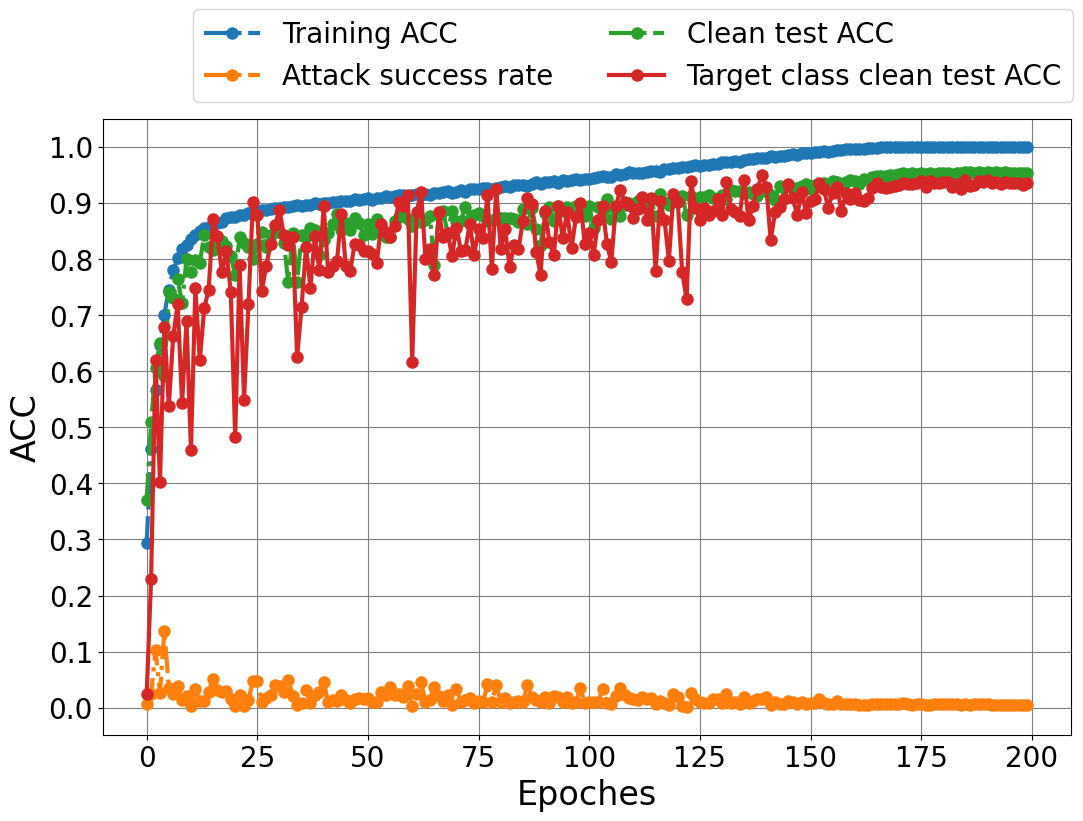

0.9999001996007985
attack 0.006
190
all class clean 0.9549
target clean 0.94


In [48]:
#cell 27
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx])
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx])
print('target clean',target_ACC[dis_idx])